# Fitbit Steps - Provenance Edition

Provenance recording using PROV (https://github.com/trungdong/prov)

In [4]:
from prov.model import ProvDocument
from prov.dot import prov_to_dot
from IPython.display import Image
from time import gmtime, strftime

Couldn't import dot_parser, loading of dot files will not be possible.


### Create a new provenance document

In [5]:
prov = ProvDocument()

### Define Provenance namespaces

In [6]:
prov.add_namespace('prov', 'http://www.w3.org/ns/prov/#')
prov.add_namespace('library', 'https://pypi.python.org/pypi/#')
prov.add_namespace('user', 'http://software.dlr.de/qs/user/#')
prov.add_namespace('fitbit_user', 'https://www.fitbit.com/user/#')
prov.add_namespace('fitbit_request', 'https://api.fitbit.com')
prov.add_namespace('method', 'http://www.python.org')
prov.add_namespace('python', 'http://www.python.org')
prov.activity('python:generateDict')
prov.add_namespace('userdata', 'http://software.dlr.de/qs/userdata/#')
prov.add_namespace('graphic', 'http://software.dlr.de/qs/graphic/#')

<Namespace: graphic {http://software.dlr.de/qs/graphic/#}>

In [7]:
% pylab inline
import fitbit
from fitbit import Fitbit, FitbitOauthClient
import pandas as pd
from pandas import DataFrame, Series
import simplejson as json
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


### Add Python modules as PROV Entities

In [8]:
prov.entity('library:fitbit', {'prov:version': fitbit.__version__ })
prov.entity('library:pandas', {'prov:version': pd.__version__})
prov.entity('library:simplejson', {'prov:version': json.__version__})
prov.entity('library:matplotlib', {'prov:version': matplotlib.__version__})
prov.entity('library:seaborn', {'prov:version': sns.__version__})

<ProvEntity: library:seaborn>

In [9]:
#from fitbit_user import user_id, access_token_secret, access_token, consumer_key, consumer_secret
# Fitbit App: Steps Analytics https://dev.fitbit.com/apps/details/229GZC
consumer_key = u'xxxxxxx'
consumer_secret = u'xxxxxxx'
user_id = u'22X4YM'

### Add the Fitbit user as PROV Agent

In [10]:
prov.agent('user:onyame@googlemail.com', {'prov:name': 'fitbit_user:%s' % user_id})

<ProvAgent: user:onyame@googlemail.com>

In [46]:
#fitbit_client = Fitbit(consumer_key, consumer_secret, user_key=access_token, user_secret=access_token_secret)

#fitbit_client = Fitbit(consumer_key, consumer_secret, resource_owner_key=access_token, resource_owner_secret=access_token_secret)
client = FitbitOauthClient(consumer_key, consumer_secret)
token = client.fetch_request_token()
print token
print client.authorize_token_url()

{u'oauth_token_secret': u'xxxxxxxxx', u'oauth_token': u'xxxxxxxxx', u'oauth_callback_confirmed': u'true'}
https://www.fitbit.com/oauth/authorize?oauth_token=xxxxxxxxx


In [5]:
print client.fetch_access_token('6caa3fdba768b7a9a199be98ca032b3e', token)

{u'oauth_token_secret': u'583fb15c715fe5507d88cf9751f94d61', u'encoded_user_id': u'22X4YM', u'oauth_token': u'xxxxxxxxx'}


In [12]:
user_token = u'xxxxxxx'
user_secret = u'xxxxxxxxx'

In [13]:
fitbit_client = Fitbit(consumer_key, consumer_secret, resource_owner_key=user_token, resource_owner_secret=user_secret)

In [14]:
user_profile = fitbit_client.user_profile_get(user_id=user_id)

## Get values from Fitbit

See https://wiki.fitbit.com/display/API/API-Get-Time-Series

In [15]:
t1 = strftime("%Y%m%dT%H%M%S%Z", gmtime())
ts = fitbit_client.time_series('activities/steps', user_id=user_id, period='1y')
t2 = strftime("%Y%m%dT%H%M%S%Z", gmtime())

In [16]:
entity_ts = prov.entity('userdata:ts')
prov.activity('fitbit_request:time_series', t1, t2)
prov.wasGeneratedBy('userdata:ts', 'fitbit_request:time_series', t2)
prov.used('fitbit_request:time_series', 'library:fitbit')
prov.wasAttributedTo(entity_ts, 'user:onyame@googlemail.com')

<ProvAttribution: (userdata:ts, user:onyame@googlemail.com)>

In [17]:
def generateDict(ts):
    steps_dict = {}
    for step in ts['activities-steps']:
        steps_dict[step['dateTime']] = int(step['value'])
    return steps_dict

In [18]:
steps = Series(generateDict(ts), name='Steps')
steps.head()

2014-10-06    11758
2014-10-07     8552
2014-10-08     9946
2014-10-09    10167
2014-10-10    13919
Name: Steps, dtype: int64

### Add conversion to Pandas Series to PROV

In [19]:
entity_steps = prov.entity('userdata:steps')
prov.wasGeneratedBy('userdata:steps', 'python:generateDict')
prov.wasDerivedFrom('userdata:steps', 'userdata:ts')
prov.used('userdata:steps', 'library:pandas')

<ProvUsage: (userdata:steps, library:pandas)>

## Produce graphics from Fitbit data

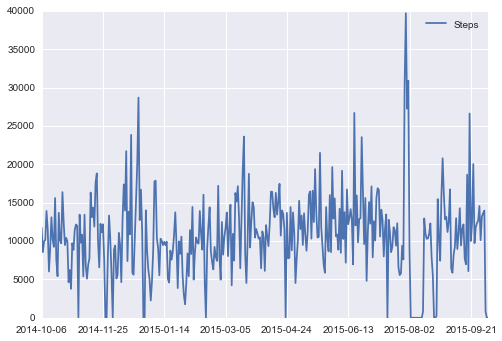

In [20]:
t1 = strftime("%Y%m%dT%H%M%S%Z", gmtime())
plt.figure(); steps.plot(label='Steps'); plt.legend(loc='best')
t2 = strftime("%Y%m%dT%H%M%S%Z", gmtime())

### Add graphics generation to PROV

In [21]:
entity_plot_steps = prov.entity('graphic:steps')

prov.activity('method:matplotlib_plot', t1, t2)
prov.used('method:matplotlib_plot', 'library:matplotlib')
prov.used('method:matplotlib_plot', 'library:seaborn')

prov.wasGeneratedBy('graphic:steps', 'method:matplotlib_plot', t2)
prov.wasDerivedFrom('graphic:steps', 'userdata:steps')

<ProvDerivation: (graphic:steps, userdata:steps)>

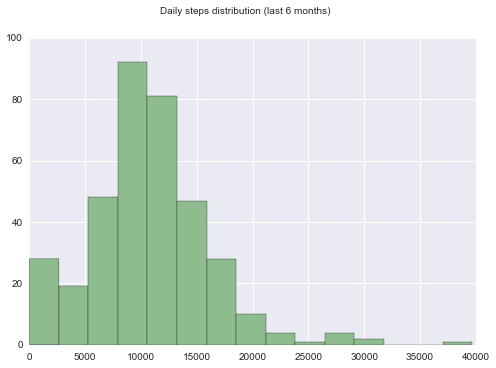

In [22]:
steps.hist(bins=15, color='darkseagreen')
plt.suptitle('Daily steps distribution (last 6 months)')

## Show the Provenance...

In [23]:
print prov.get_provn()

document
  prefix userdata <http://software.dlr.de/qs/userdata/#>
  prefix graphic <http://software.dlr.de/qs/graphic/#>
  prefix fitbit_request <https://api.fitbit.com>
  prefix fitbit_user <https://www.fitbit.com/user/#>
  prefix user <http://software.dlr.de/qs/user/#>
  prefix method <http://www.python.org>
  prefix library <https://pypi.python.org/pypi/#>
  prefix prov_1 <http://www.w3.org/ns/prov/#>
  
  activity(method:generateDict, -, -)
  entity(library:fitbit, [prov:version="0.1.3"])
  entity(library:pandas, [prov:version="0.16.2"])
  entity(library:simplejson, [prov:version="3.6.5"])
  entity(library:matplotlib, [prov:version="1.4.3"])
  entity(library:seaborn, [prov:version="0.5.0"])
  agent(user:onyame@googlemail.com, [prov:name="fitbit_user:22X4YM"])
  entity(userdata:ts)
  activity(fitbit_request:time_series, 2015-10-04T22:57:39+02:00, 2015-10-04T22:57:39+02:00)
  wasGeneratedBy(userdata:ts, fitbit_request:time_series, 2015-10-04T22:57:39+02:00)
  used(fitbit_request:time

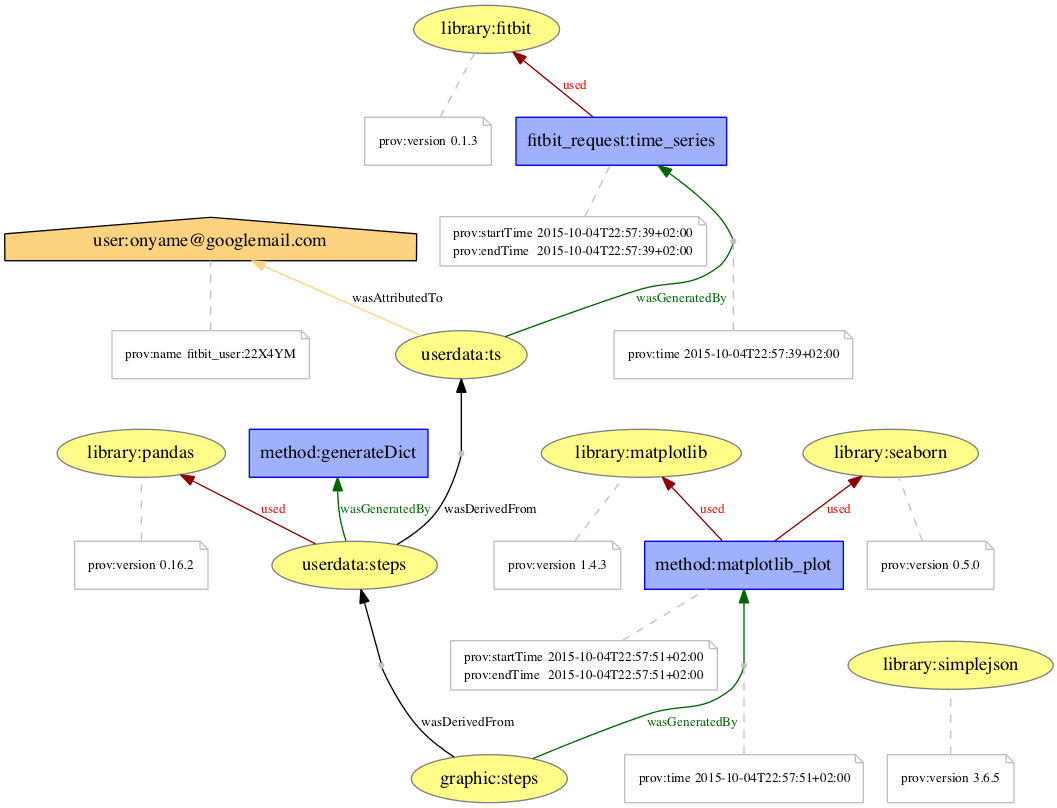

In [24]:
dot = prov_to_dot(prov)
dot.write_png('fitbit-prov.png')
Image('fitbit-prov.png')

In [25]:
print generateDict.func_code.co_varnames


('ts', 'steps_dict', 'step')


## Store in ProvStore (https://provenance.ecs.soton.ac.uk/store)

In [2]:
from provstore.api import Api

# API key can be found at https://provenance.ecs.soton.ac.uk/store/account/developer/
api = Api(username="onyame", api_key="103b7d3543c6164c9fe7a51f5d388affe3c7cbd2 ")

In [26]:
stored_document = api.document.create(prov,
                                      name="Fitbit2",
                                      public=False)

In [27]:
print stored_document

https://provenance.ecs.soton.ac.uk/store/api/v0/documents/112945
